In [1]:
from regression import fixedX_pwlr as fxpwlr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
coverage_fn = 'data/coverage_df.csv.gz'
def read_coverage_df(coverage_fn):
	coverage_df = pd.read_csv(coverage_fn, header=0, index_col=None, sep = '\t', compression='gzip')
	# if columns of coverage_df is '0' or '1', '2', '3', change it to integer
	curr_columns = list(coverage_df.columns.copy())
	for idx, col in enumerate(curr_columns):
		try:
			col = int(col)
			curr_columns[idx] = col
		except:
			pass
	coverage_df.columns = curr_columns
	return coverage_df

def drop_trailing_zeros(df):
    '''
    Given a df, we want to get rid of all the rows at the end where all the values are zero
    :param df:
    :return:
    '''
    mask = (df != 0).any(axis=1)  # Create a mask where rows with any non-zero values are True
    return df.iloc[:int(mask[::-1].idxmax() + 1)]  # Reverse mask, find first True from end, slice DataFrame

def calculate_culmulative_coverage(coverage_df):
    """
    Given the coverage_df, clean the coverage_df to make sure that the coverage at each timepoint is the culmulative coverage
    :param coverage_df: time-tagged coverage_df
    :param gapN: every gapN rows in the coverage_df, we will include a row to include into the piece-wise linear regression
    :return:
    """
    # Assuming df is your DataFrame
    df_cumulative = coverage_df.drop('position', axis=1).cumsum(axis=1) # do not change the location of this line of code
    # find the rows where the coverage is zero for all time points, and remove them
    df_cumulative = drop_trailing_zeros(df_cumulative)
    df_cumulative['position'] = coverage_df['position'] # put the position back in
    return df_cumulative

def get_full_coverage(coverage_df):
    '''
    For each time point, calculate the cumulative coverage
    '''
    full_coverage_df = coverage_df.copy()
    full_coverage_df['position'] = coverage_df['position']/1000  #convert genomic position to kb
    coverage_df['position'] = coverage_df['position']/1000  #convert genomic position to kb
    GAP=10
    full_coverage_df = calculate_culmulative_coverage(full_coverage_df)
    full_coverage_df = full_coverage_df.loc[::GAP]  # we do not need to plot every datapoints
    coverage_df = coverage_df.loc[::GAP]  # we do not need to plot every datapoints
    coverage_df.reset_index(drop=True, inplace=True)
    full_coverage_df.reset_index(drop=True, inplace=True)
    return coverage_df, full_coverage_df

def _prepare_data_for_pwlr(full_coverage_df, time_idx):
    '''
    Look at the full_coverage_df and prepare the data: X: positions, Y: coverage at time_idx.
    Only select data from positions such that we get rid of trailing zeroes in coverage
    :param time_idx:
    :return:
    '''
    mask = (full_coverage_df[[time_idx]] != 0).any(axis=1)  # Create a mask where rows with any non-zero values are True
    end_idx = int(mask[::-1].idxmax() + 1)
    X = (full_coverage_df['position'].iloc[:end_idx].values).copy()  # Reverse mask, find first True from end, slice DataFrame
    Y = (full_coverage_df[time_idx].iloc[:end_idx].values).copy() # Reverse mask, find first True from end, slice DataFrame
    x_min = X.min()
    x_max = X.max()
    return X, Y, x_min, x_max
    
coverage_df = read_coverage_df(coverage_fn)
coverage_df, full_coverage_df = get_full_coverage(coverage_df)  # position (kb), time points (cumulative coverage)
print(full_coverage_df.head())

     0    1    2  position
0  335  483  624      0.00
1  334  483  622      0.01
2  334  483  622      0.02
3  334  483  620      0.03
4  333  479  618      0.04


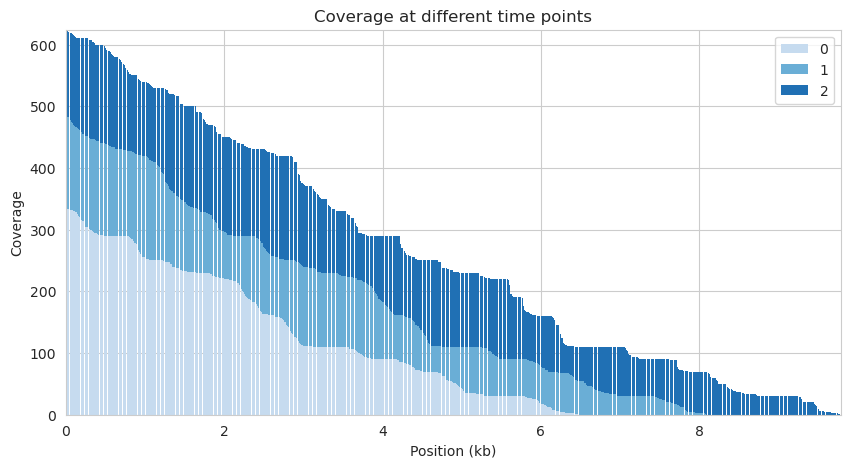

In [15]:
# draw the data of full_coverage_df
num_timepoints = full_coverage_df.shape[1]-1
cmap = sns.color_palette('Blues', n_colors=num_timepoints)
colors = [cmap[i] for i in range(num_timepoints)]
fig, ax = plt.subplots(figsize=(10, 5))
width = 0.85* 0.01 # the width of the bars should never exceed the numerical distance between each of the x-axis value
plot_df = coverage_df.copy()

for time_idx in range(3):  # we want to plot the regression lines for the endT_idx as well
    bottom = np.zeros(len(plot_df['position']))
    if time_idx > 0:
        bottom = full_coverage_df[time_idx-1].values
    ax.bar(plot_df['position'], plot_df[time_idx], color=colors[time_idx], bottom = bottom,  label=time_idx, width=width, linewidth=0)
ax.set_xlim(0, full_coverage_df['position'].max())
ax.set_ylim(0, full_coverage_df.max().max())
ax.set_xlabel('Position (kb)')
ax.set_ylabel('Coverage')
ax.set_title('Coverage at different time points')
ax.legend()

/gladstone/engelhardt/home/hvu/source/RNA_rates/splicingrates/simulations/regression/fixedX_pwlr.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.tensor(indices, dtype=torch.long)
/gladstone/engelhardt/home/hvu/source/RNA_rates/splicingrates/simulations/regression/fixedX_pwlr.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.tensor(indices, dtype=torch.long)


Saving figure to: data/fxlr_0.png
Saving figure to: data/fxlr_1.png


/gladstone/engelhardt/home/hvu/source/RNA_rates/splicingrates/simulations/regression/fixedX_pwlr.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.tensor(indices, dtype=torch.long)


Saving figure to: data/fxlr_2.png
Done getting fxlr_dict


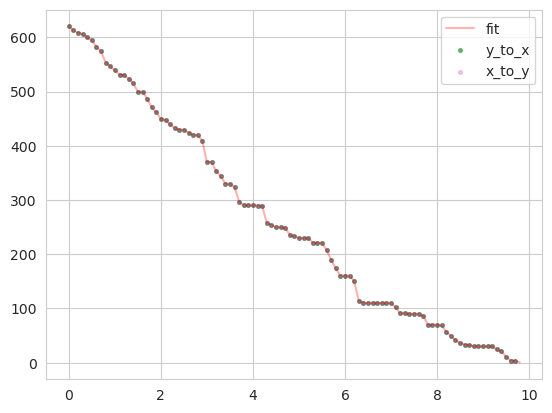

In [25]:
time_indices = [0, 1, 2]
output_folder = 'data'
fxlr_dict = {}  # keys: time_idx, values: fxlr_model for that time_idx
gapX_for_draw = 10
regress_bin=0.1  # the bin size for the fixed_bin piecewise linear regression
for time_idx in time_indices:
    X, Y, x_min, x_max = _prepare_data_for_pwlr(full_coverage_df, time_idx)  # parepare the data for the piecewise linear regression
    save_fn = f'{output_folder}/fxlr_{time_idx}.txt'
    if os.path.exists(save_fn):
        fxlr_model = fxpwlr.load_model(save_fn)
        fxlr_dict[time_idx] = fxlr_model
        fxlr_model.draw_regression_results(X[::gapX_for_draw], save_fn=f'{output_folder}/fxlr_{time_idx}.png')  # draw a few points to verify that the regression calculation (x_to_y and y_to_x) is correct
        continue
    fxlr_model = fxpwlr.PiecewiseLinearRegression(x_min=x_min, x_max=x_max, gap = regress_bin)
    fxlr_model.fit(X, Y)
    fxlr_dict[time_idx] = fxlr_model
    fxlr_model.save_model(save_fn)
    fxlr_model.draw_regression_results(X[::gapX_for_draw], save_fn=f'{output_folder}/fxlr_{time_idx}.png')  # draw a few points to verify that the regression calculation (x_to_y and y_to_x) is correct
print('Done getting fxlr_dict')

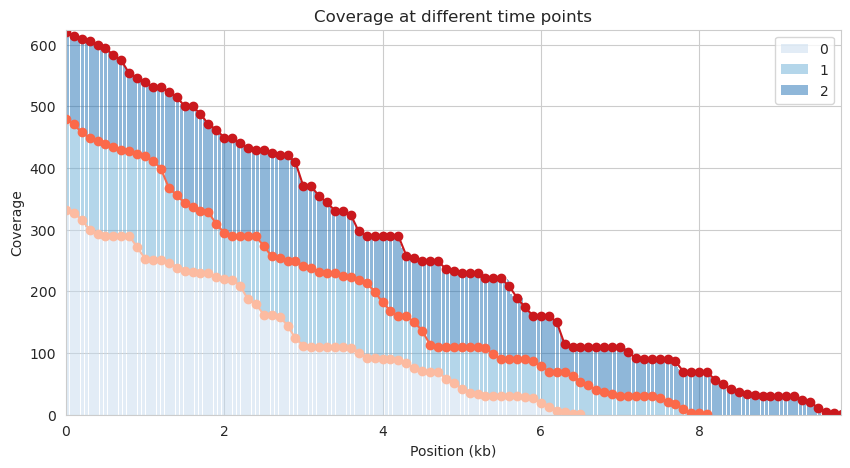

In [26]:
# draw the data of full_coverage_df along with the regression lines
fig, ax = plt.subplots(figsize=(10, 5))
width = 0.85* 0.01 # the width of the bars should never exceed the numerical distance between each of the x-axis value
plot_df = coverage_df.copy()
num_timepoints = full_coverage_df.shape[1]-1
blue_colors = sns.color_palette('Blues', n_colors=num_timepoints)
red_colors = sns.color_palette('Reds', n_colors=num_timepoints)
for time_idx in range(num_timepoints):  # we want to plot the regression lines for the endT_idx as well
    bottom = np.zeros(len(plot_df['position']))
    if time_idx > 0:
        bottom = full_coverage_df[time_idx-1].values
    ax.bar(plot_df['position'], plot_df[time_idx], color=blue_colors[time_idx], bottom = bottom,  label=time_idx, width=width, linewidth=0, alpha=0.5)
    fxlr_model = fxlr_dict[time_idx]
    px, py = fxlr_model.px.detach().numpy(), fxlr_model.py.detach().numpy()
    ax.plot(px, py, '-o', color=red_colors[time_idx])  # red

ax.set_xlim(0, full_coverage_df['position'].max())
ax.set_ylim(0, full_coverage_df.max().max())
ax.set_xlabel('Position (kb)')
ax.set_ylabel('Coverage')
ax.set_title('Coverage at different time points')
ax.legend()
plt.savefig('data/fxlr.png')

In [22]:
# now let's try to do change point detection with learned breakpoints
from regression import piecewise_linear_regression as pwlr
time_indices = [0, 1, 2]
output_folder = 'data'
pwlr_model_dict = {}  # keys: time_idx, values: fxlr_model for that time_idx
for time_idx in time_indices:
    pwlr_model = pwlr.PiecewiseLinearRegression()
    pwlr_model.fit(full_coverage_df.loc[::50]['position'].values, full_coverage_df.loc[::50][time_idx].values)
    pwlr_model_dict[time_idx] = pwlr_model
    save_fn = f'{output_folder}/pwlr_{time_idx}.npz'
    pwlr_model.save_model(save_fn)
print('Done getting pwlr_dict')

Done getting pwlr_dict


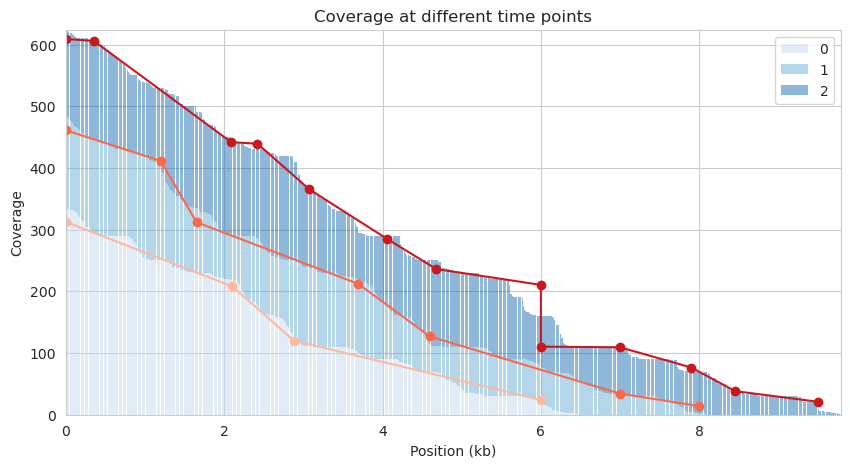

In [24]:
# draw the data of full_coverage_df along with the regression lines
fig, ax = plt.subplots(figsize=(10, 5))
width = 0.85* 0.01 # the width of the bars should never exceed the numerical distance between each of the x-axis value
plot_df = coverage_df.copy()
num_timepoints = full_coverage_df.shape[1]-1
blue_colors = sns.color_palette('Blues', n_colors=num_timepoints)
red_colors = sns.color_palette('Reds', n_colors=num_timepoints)
for time_idx in range(num_timepoints):  # we want to plot the regression lines for the endT_idx as well
    bottom = np.zeros(len(plot_df['position']))
    if time_idx > 0:
        bottom = full_coverage_df[time_idx-1].values
    ax.bar(plot_df['position'], plot_df[time_idx], color=blue_colors[time_idx], bottom = bottom,  label=time_idx, width=width, linewidth=0, alpha=0.5)
    pwlr_model = pwlr_model_dict[time_idx]
    px, py = pwlr_model.px, pwlr_model.py
    ax.plot(px, py, '-o', color=red_colors[time_idx])  # red

ax.set_xlim(0, full_coverage_df['position'].max())
ax.set_ylim(0, full_coverage_df.max().max())
ax.set_xlabel('Position (kb)')
ax.set_ylabel('Coverage')
ax.set_title('Coverage at different time points')
ax.legend()
plt.savefig('data/pwlr.png')